# Polarización con organismos centrales

El objetivo de este capítulo es explorar el impacto que tiene la inserción de organismos centrales dentro de una comunidad de agentes que actualizan sus creencias. La incorporación de esta característica permite modelar situaciones empíricas donde los agentes tienen acceso a una fuente común de información, como por ejemplo medios de comunicación masivos.

Concretamente, el resultado que se busca analizar es qué impacto tiene la presencia de medios de comunicación en comunidades epistémicas. En esta primera versión, el modelo será puramente *doxástico*, *i.e.*, no habrá una opinión que sea verdadera, sino que los agentes sólo tendrán opiniones tomadas de una distribución uniforme. En este contexto, el organismo central emitirá una señal constante que represente alguna de estas opiniones.

En los capítulos subsiguientes se explorarán modelos *factuales* en donde algún valor de la distribución sea la posición verdadera y donde los agentes dispongan de algún mecanismo epistémico para aproximarse a dicha verdad. Adicionalmente, se investigará una segunda extensión del modelo en donde las creencias de los agentes serán complejas y no restringidas a un único valor.

# Modelo de dinámica de opiniones JA (Jager, Amblard)

El modelo de dinámica de opiniones JA es presentado en {cite:p}`jager2005`. Su objetivo es ofrecer una reconstrucción formal de la Teoría del Juicio Social (SJT) {cite:p}`sherif1961`. El mecanismo utilizando en esta reconstrucción es similar al modelo de Bounded Confidence {cite:p}`hegselmann2002` y de Relative Agreement {cite:p}`deffuant2002` en la medida en que la simulación consiste de una población de agentes con opiniones continuas que en cada paso actualizan sus opiniones dialogando con los agentes que se parecen a ellos.

La novedad de este modelo es que distingue *tres actitudes* que los agentes pueden tomar frente a nueva información:
- **Aceptación**: cuando una opinión es lo suficientemente similar a la opinión de un agente (es decir, cuando cae dentro de su *latitud de aceptación*), el segundo agente actualizará sus opinión acercándose a la opinión nueva.
- **Rechazo**: cuando un agente se encuentra frente a la opinión de otro agente que es muy distinta a la suya (es decir, cuando cae dentro de su *latitud de rechazo*), el agente actualizará su opinión alejándose de la opinión nueva.
- **No compromiso**: en otro caso, el agente no tomará ninguna acción respecto a la opinión nueva.

En términos formales, la simulación consiste en una población de $N$ agentes, donde cada agente $i$ consiste de
- Una opinión $x_i$;
- Un umbral determinando la latitud de aceptación $u_i$;
- Un umbral determinando la latitud de rechazo $t_i$, donde $t_i > u_i$.

De esta forma pueden modelarse agentes con distintas estructuras actitudinales. Por ejemplo, un agente muy egocéntrico será un agente donde $t_i$ sea apenas más grande o igual a $u_i$, de manera que rechazará inmediatamente todo aquello que no acepte.

La simulación es de a pares, *i.e.*, en cada paso de la simulación se establecen pares de agentes para que se comuniquen entre sí (similar al modelo RA). En cada paso, la influencia que tendrá un agente sobre otro queda determinada por las siguientes reglas

\begin{align*}
\text{Si} \ |x_i - x_j| < u_i \quad \delta x_i &= \mu \cdot (x_j - x_i)\\
\text{Si} \ |x_i - x_j| > t_i \quad \delta x_i &= \mu \cdot (x_i - x_j)
\end{align*}

Una vez definida la influencia, la nueva opinión del agente es el resultado de sumar su antigua opinión con la influencia recibida (acotado a los valores máximo y mínimo de la distribución):

$$
x_{it+1} \begin{cases}
min(1, \ x_i + \delta x_i) & \text{si } x_i + \delta x_i > 0 \\
max(-1, \ x_i + \delta x_i) & \text{si } x_i + \delta x_i < 0
\end{cases}
$$

En una primera instancia, el modelo se inicializa con las opiniones de los agentes tomadas de una distribució uniforme entre $\left[ -1; 1 \right]$, y con una misma incertidumbre $U$ y un mismo umbral de rechazo $T$.

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from computational_social_epistemology import (
    SocialJudgementModel,
    HeterogeneousJAModel,
    OpinionDistributionAnalyzer,
    sample_agent_types,
    plot_agent_type_regions,
    generate_systematic_configs
)
from computational_social_epistemology.metrics import (
    generate_polarization_report, 
    print_polarization_report
)

## Modelando distintas estructuras actitudinales

Como se mencionó anteriormente, diferentes elecciones de los parámetros $U$ y $T$ resultan en distintas configuraciones de agentes. A continuación se presenta una serie de experimentos que exploran este espacio de parámetros.

En todos los experimentos subsiguientes se setea la velocidad de la simulación $\mu = 0.1$. A su vez, para conservar la simpleza de los experimentos se definen valores idénticos de $U$ y $T$ para todos los agentes.

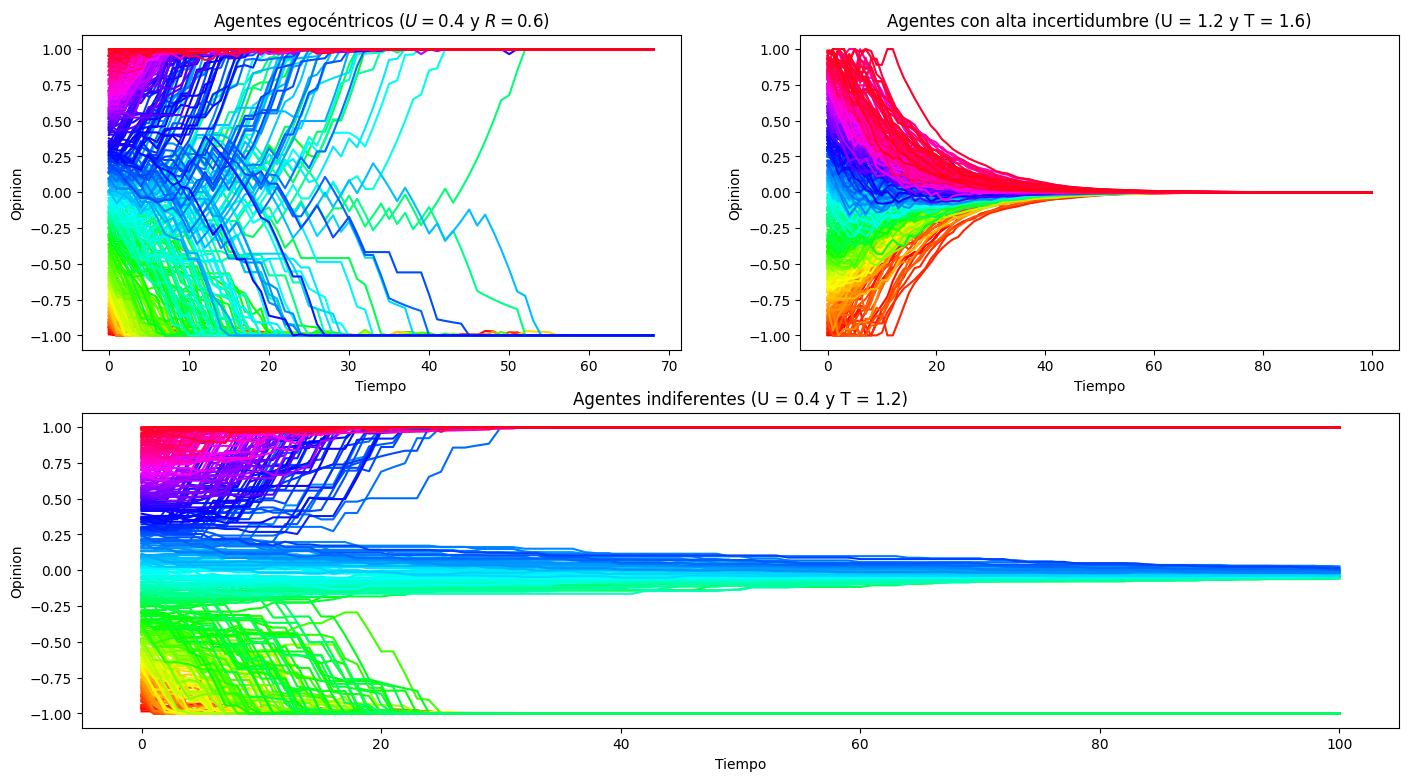

In [6]:
experiments = {
    "Agentes egocéntricos ($U = 0.4$ y $R = 0.6$)": dict(
        n      = 400,
        mu     = .1,
        u      = 0.4,
        t      = 0.6,
        epochs = 100,
    ),
    "Agentes con alta incertidumbre (U = 1.2 y T = 1.6)": dict(
        n      = 400,
        mu     = .1,
        u      = 1.2,
        t      = 1.6,
        epochs = 100
    ),
    "Agentes indiferentes (U = 0.4 y T = 1.2)": dict(
        n      = 400,
        mu     = .1,
        u      = 0.4,
        t      = 1.2,
        epochs = 100
    ),
}

fig = plt.figure(figsize=(17,9))
gs = fig.add_gridspec(2,2)
# set axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

axs = [ax1, ax2, ax3]
executed_models = []

for idx, (name, params) in enumerate(experiments.items()):
    model = SocialJudgementModel(**params)
    # get ax for plotting
    ax = axs[idx]
    # disable progress bar
    model.v = False
    # run the experiment
    model.run()
    executed_models.append(model)
    # generate plot
    model.plot_results(ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Opinion")

### Agentes egocéntricos

Un agente será egocéntrico en caso que rechace todas las opiniones que estén por fuera de su rango de aceptación. En términos de los parámetros del modelo, esto se traduce como un agente donde $t_i$ es apenas mayor o igual a $u_i$. Para explorar esta situación, se establecen los siguientes valores:
$$
U = 0.4 \\
T = 0.6
$$

En una simulación con este tipo de agentes, el resultado obtenido es un patrón de polarización en los extremos. Esto ocurre ya que los agentes serán muy propensos a contrastar con otros agentes, ya que su región de rechazo será muy grande.

In [7]:
report = generate_polarization_report(executed_models[0])
print_polarization_report(report)


Polarization Analysis Report
+-------------------------+-----------+---------+----------+
| Metric                  |   Initial |   Final |   Change |
+=========================+===========+=========+==========+
| spread                  |     1.993 |   2     |    0.007 |
+-------------------------+-----------+---------+----------+
| dispersion              |     0.504 |   0.999 |    0.495 |
+-------------------------+-----------+---------+----------+
| coverage                |     1     |   0.1   |   -0.9   |
+-------------------------+-----------+---------+----------+
| regionalization         |     0     |   1     |    1     |
+-------------------------+-----------+---------+----------+
| group_distinctness      |     0.909 |   1     |    0.091 |
+-------------------------+-----------+---------+----------+
| group_divergence        |     0.935 |   2     |    1.065 |
+-------------------------+-----------+---------+----------+
| group_consensus         |     0.921 |   1     |    0.

### Agentes con alta incertidumbre

Un agente tendrá alta incertidumbre en caso que tenga una región de aceptación grande y una región de no compromiso pequeña. Esto significará que cada agente estará abierto a acercarse a opiniones muy diversas a la suya, pero teniendo un compromiso con la actualización de sus creencias (dado que habrá pocos casos en donde no se comprometa).

Esto puede modelarse asignando los siguientes valores a los parámetros:
$$
U = 1.2 \\
T = 1.6
$$

En una simulación de este tipo, el resultado será que los agentes converjan a una opinión central.

In [9]:
report = generate_polarization_report(executed_models[1])
print_polarization_report(report)


Polarization Analysis Report
+-------------------------+-----------+---------+----------+
| Metric                  |   Initial |   Final |   Change |
+=========================+===========+=========+==========+
| spread                  |     1.988 |   0     |   -1.988 |
+-------------------------+-----------+---------+----------+
| dispersion              |     0.512 |   0     |   -0.512 |
+-------------------------+-----------+---------+----------+
| coverage                |     1     |   1     |    0     |
+-------------------------+-----------+---------+----------+
| regionalization         |     0     |   0     |    0     |
+-------------------------+-----------+---------+----------+
| group_distinctness      |     0.761 |   0.836 |    0.075 |
+-------------------------+-----------+---------+----------+
| group_divergence        |     1.025 |   0     |   -1.025 |
+-------------------------+-----------+---------+----------+
| group_consensus         |     0.876 |   0.937 |    0.

### Agentes indiferentes

Un agente será indiferente en caso que tenga una gran región de no compromiso. Esto querrá decir que sólo aceptará aquellas opiniones que se parezcan mucho a la suya y que sólo rechazará aquellas que sean muy diferentes a la suya, siendo indiferente respecto de todas las demás.

Esto puede modelarse asignando los siguientes valores a los parámetros de la simulación:

$$
U = 0.4 \\
T = 1.2
$$

El resultado de esta simulación reflejará tanto un patrón de convergencia central como también un patrón de polarización en los extremos. Esto se produce ya que los agentes que se inicializan cerca de la opinón central tenderán a ponerse de acuerdo entre sí y quedarse cerca de la media, mientras que los agentes que comienzan con opiniones extremas se opondrán a los del otro extremo y se segregarán.

In [10]:
report = generate_polarization_report(executed_models[2])
print_polarization_report(report)


Polarization Analysis Report
+-------------------------+-----------+---------+----------+
| Metric                  |   Initial |   Final |   Change |
+=========================+===========+=========+==========+
| spread                  |     1.985 |   2     |    0.015 |
+-------------------------+-----------+---------+----------+
| dispersion              |     0.504 |   0.791 |    0.286 |
+-------------------------+-----------+---------+----------+
| coverage                |     1     |   0.2   |   -0.8   |
+-------------------------+-----------+---------+----------+
| regionalization         |     0     |   0     |    0     |
+-------------------------+-----------+---------+----------+
| group_distinctness      |     0.761 |   1     |    0.239 |
+-------------------------+-----------+---------+----------+
| group_divergence        |     1.01  |   1.333 |    0.323 |
+-------------------------+-----------+---------+----------+
| group_consensus         |     0.877 |   0.998 |    0.

# Agregando organismos centrales

Habiendo presentado el modelo de dinámica de opiniones basado en la SJT, se tiene una base propicia para explorar el impacto que tiene dentro de una comunidad de agentes la inserción de un organismo central.

En términos del modelo, un organismo central $O$ se define como una señal constante que todos los agentes recibirán por igual. De esta manera, en cada paso de la simulación los agentes actualizarán su opinión con respecto a la señal recibida por parte del organismo central, y luego actualizarán sus creencias a partir de la interacción con otro agente.

In [5]:
class CentralOrganismModel(SocialJudgementModel):

    def __init__(self, n, mu, u, t, o, epochs, v=False):
        super().__init__(n, mu, u, t, epochs, v)
        self.o = o

    def update(self, opinion_profile):
        # actualización con organismo central
        opinion_profile = np.array([
            self.individual_update(opinion, self.o)
            for opinion in opinion_profile
        ])
        # actualización con pares
        random_pairs_idxs = np.random.choice(a=self.n, replace=False,
                                             size=(int(self.n / 2), 2))
        random_pairs = opinion_profile[random_pairs_idxs]
        update_result = np.array(list(map(self.pairwise_update, random_pairs)))
        new_profile = np.empty((self.n))
        new_profile[random_pairs_idxs.reshape(-1)] = update_result.reshape(-1)
        return new_profile.reshape(-1, 1)

    def plot_results(self):
        fig, ax = plt.subplots(figsize=(13,6))
        # opinión central
        ax.hlines(xmin=0, xmax=self.history.shape[1],
                  y=self.o, colors='black')
        # opiniones de los agentes
        cmap = plt.get_cmap('hsv', self.n)
        x = np.arange(self.history.shape[1])

        for agent in range(self.n):
            ax.plot(x, self.history[agent, :], color=cmap(agent))

## Modelando estructuras actitudinales y su interacción con el organismo central

A continuación se corren simulaciones con los mismos parámetros explorados anteriormente: agentes egocéntricos, agentes con alta incertidumbre y agentes indiferentes. El objetivo es analizar cómo se comportan estos tipos de agentes frente a la presencia de un organismo central.

### Agentes egocéntricos

Este primer ressultado ya es muy sugerente. A diferencia de la simulación sin un organismo central, se observa que la presencia de este agente produce un gran factor de polarización.

 63%|██████▎   | 63/100 [00:00<00:00, 403.68it/s]


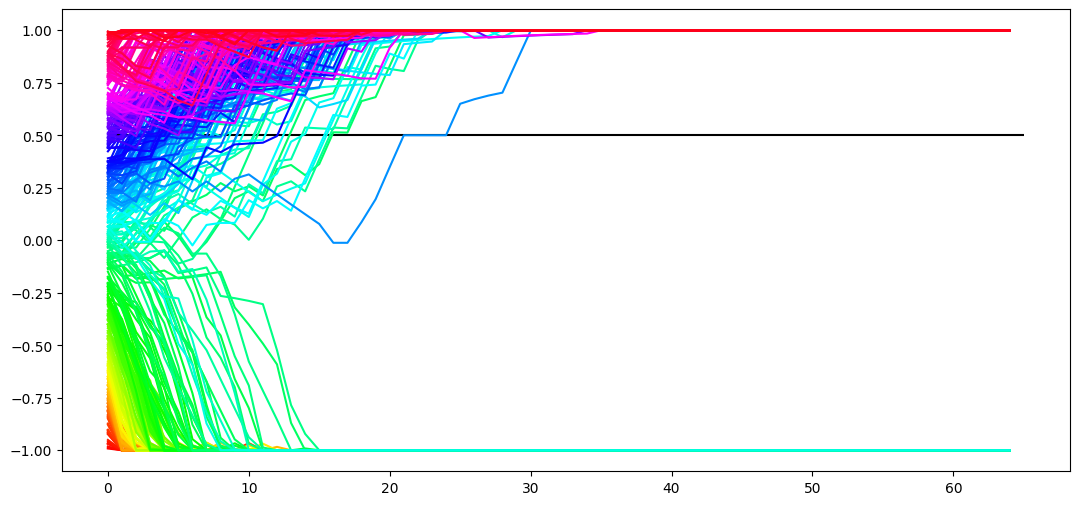

In [ ]:
com = CentralOrganismModel(
    n = 400,
    mu = .1,
    u = .4,
    t = .6,
    o = .5,
    epochs = 100,
)

com.run()
com.plot_results()

### Agentes con alta incertidumbre

En el caso de los agentes con alta incertidumbre, la incorporación de un organismo central produce que las opiniones converjan en la señal pública.

Esto sucede porque los agentes tienen una alta probabilidad de aceptar una opinión diferente a la suya por más que sea muy diferente. Por lo tanto, incluso los agentes que empiezan la simulación pensando muy diferente de la señal pública terminan adoptándola

100%|██████████| 100/100 [00:00<00:00, 444.83it/s]


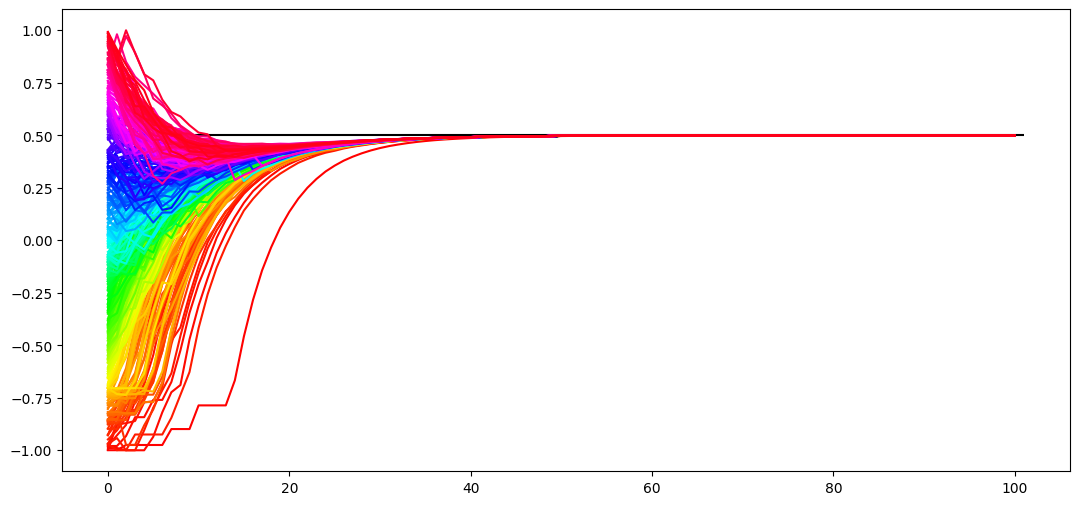

In [ ]:
com = CentralOrganismModel(
    n = 400,
    mu = .1,
    u = 1.2,
    t = 1.6,
    o = .5,
    epochs = 100,
)

com.run()
com.plot_results()

### Agentes indiferentes

En el caso de los agentes indiferentes, la dinámica es bastante similar a aquella en donde no existe un organismo central.

Sin embargo, se puede observar que el grupo de agentes que comienzan la simulación en el centro de la distribución se corre un poco respecto de la señal pública. Esto indica que la presencia de un organismo central aporta a una dinámica de corrimiento hacia los extremos de las opiniones.

 68%|██████▊   | 68/100 [00:00<00:00, 443.37it/s]


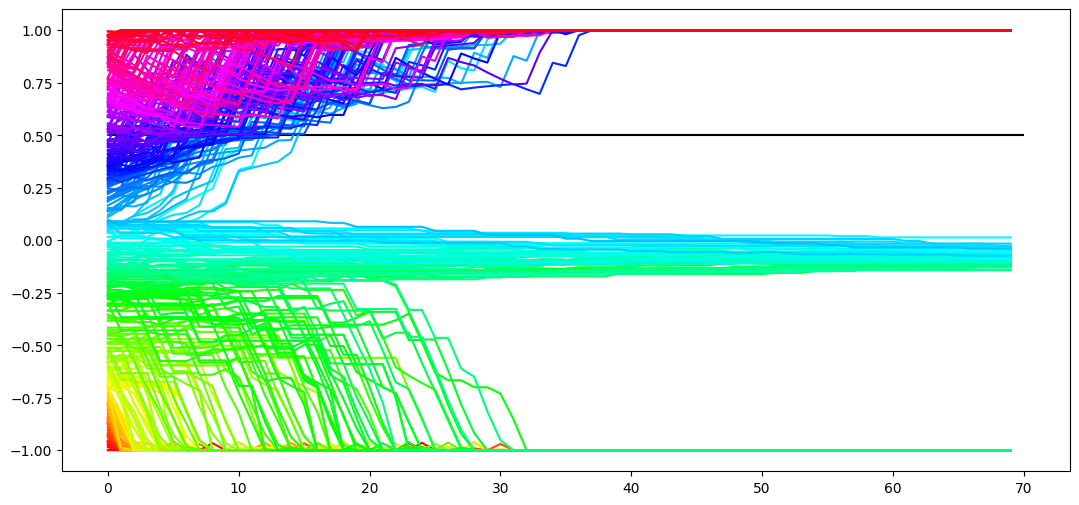

In [ ]:
com = CentralOrganismModel(
    n = 400,
    mu = .1,
    u = .4,
    t = 1.2,
    o = .5,
    epochs = 100,
)

com.run()
com.plot_results()